# DESI spectral fitting on NERSC
In this jupyter notebook, I'll demonstrate how we can use the `provabgs` pipeline to fit DESI spectra! This notebook uses the DESI master jupyter notebook kernel (see [Jupyter on NERSC](https://desi.lbl.gov/trac/wiki/Computing/JupyterAtNERSC) for instructions). 

In [1]:
# lets install the python package `provabgs`, a python package for generating the PRObabilistic Value-Added BGS (PROVABGS)
!pip install git+https://github.com/changhoonhahn/provabgs.git --upgrade --user

  Cloning https://github.com/changhoonhahn/provabgs.git to /tmp/pip-req-build-mh3cw15n
  Running command git clone -q https://github.com/changhoonhahn/provabgs.git /tmp/pip-req-build-mh3cw15n
  Created wheel for provabgs: filename=provabgs-0.1-py3-none-any.whl size=25047521 sha256=9e9f78ebdf3e0e15177848b5ec0c34a21cd655e511ed7b2e16798f02b1a625c1
  Stored in directory: /tmp/pip-ephem-wheel-cache-qat029_x/wheels/50/b1/8c/96efdb74859fd559b23907d6b38eb2a97aa8362da66cbb7437
Successfully built provabgs
  Attempting uninstall: provabgs
    Found existing installation: provabgs 0.1
    Uninstalling provabgs-0.1:
      Successfully uninstalled provabgs-0.1


In [39]:
!pip install corner

Defaulting to user installation because normal site-packages is not writeable
  Using cached corner-2.2.1-py3-none-any.whl (15 kB)


In [2]:
import numpy as np

In [3]:
from provabgs import infer as Infer
from provabgs import models as Models
from provabgs import flux_calib as FluxCalib

/global/homes/c/chahah/.local/lib/python3.8/site-packages/provabgs/models.py:25: UserWarning: import error with fsps; only use emulators
  warnings.warn('import error with fsps; only use emulators')


In [40]:
# make pretty plots
import corner
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['axes.linewidth'] = 1.5
mpl.rcParams['axes.xmargin'] = 1
mpl.rcParams['xtick.labelsize'] = 'x-large'
mpl.rcParams['xtick.major.size'] = 5
mpl.rcParams['xtick.major.width'] = 1.5
mpl.rcParams['ytick.labelsize'] = 'x-large'
mpl.rcParams['ytick.major.size'] = 5
mpl.rcParams['ytick.major.width'] = 1.5
mpl.rcParams['legend.frameon'] = False

## read in DESI Denali spectra
Lets read in an arbitrary BGS galaxy spectra from the Denali reduction

In [5]:
# read in DESI Denali spectra from TILE 80612
from desispec.io import read_spectra

spectra = read_spectra('/global/cfs/cdirs/desi/spectro/redux/denali/tiles/cumulative/80612/20201223/coadd-0-80612-thru20201223.fits')

INFO:spectra.py:253:read_spectra: iotime 0.527 sec to read coadd-0-80612-thru20201223.fits at 2021-06-14T05:56:49.960084


In [6]:
# pick arbitrary BGS galaxy
igal = 10

In [7]:
# read in redshift from redrock output
from astropy.table import Table
zbest = Table.read('/global/cfs/cdirs/desi/spectro/redux/denali/tiles/cumulative/80612/20201223/zbest-0-80612-thru20201223.fits', hdu=1)
zred = zbest['Z'][igal]
print('z=%f' % zred)

z=0.291233


Here's what the galaxy spectra looks like

(-0.5, 5.0)

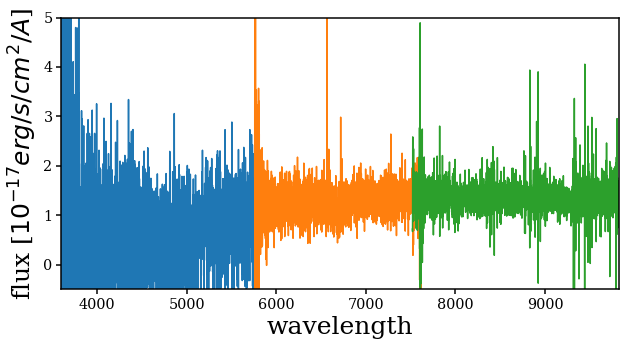

In [8]:
fig = plt.figure(figsize=(10,5))
sub = fig.add_subplot(111)
sub.plot(spectra.wave['b'], spectra.flux['b'][igal])
sub.plot(spectra.wave['r'], spectra.flux['r'][igal])
sub.plot(spectra.wave['z'], spectra.flux['z'][igal])
sub.set_xlabel('wavelength', fontsize=25)
sub.set_xlim(spectra.wave['b'].min(), spectra.wave['z'].max())
sub.set_ylabel('flux [$10^{-17} erg/s/cm^2/A$]', fontsize=25)
sub.set_ylim(-0.5, 5)

## Bayesian spectral SED modeling 
The `provabgs` python package provides all the tools you need to conduct a Bayesian SED modeling of DESI spectra using a full MCMC. You need to
1. specify the prior
2. specify the SED model
3. specify the flux calibration model

In the following example, I'll a default (recommended) prior, the NMF SED model (without starburst, with emulator), and no flux calibration (since we're fitting only the spectra). 

In [9]:
# 1. specify the prior
priors = Infer.default_NMF_prior(burst=False) 

In [10]:
# 2. specify the SED model, without starburst, with emulator
m_sed = Models.NMF(burst=False, emulator=True)

input parameters : logmstar, beta1_sfh, beta2_sfh, beta3_sfh, beta4_sfh, gamma1_zh, gamma2_zh, dust1, dust2, dust_index


In [11]:
# 3. specify the flux calibration (for jointly fitting photometry and spectra, you will need a more flexible flux calibration function)
fluxcalib = FluxCalib.no_flux_factor

plug in the prior, SED model, and flux calibration model into a `infer.desiMCMC` object

In [12]:
desi_mcmc = Infer.desiMCMC(
    model=m_sed, 
    flux_calib=fluxcalib, 
    prior=priors
)

then run MCMC using `zeus` ensemble slice sampling method (see https://zeus-mcmc.readthedocs.io/), `emcee` is also supported

In [13]:
mcmc = desi_mcmc.run(
    wave_obs=[spectra.wave['b'], spectra.wave['r'], spectra.wave['z']],
    flux_obs=[spectra.flux['b'][igal], spectra.flux['r'][igal], spectra.flux['z'][igal]],
    flux_ivar_obs=[spectra.ivar['b'][igal], spectra.ivar['r'][igal], spectra.ivar['z'][igal]],
    zred=zred, 
    sampler='zeus',
    nwalkers=30, 
    burnin=100,
    opt_maxiter=10000,
    niter=2000, 
    debug=True # if True, you'll see a bunch of diagnostic print 
)

--- initializing the walkers ---


/global/homes/c/chahah/.local/lib/python3.8/site-packages/provabgs/models.py:646: RuntimeWarning: overflow encountered in exp
  layers.append((betas_[i] + (1.-betas_[i])*1./(1.+np.exp(-alphas_[i]*act[-1])))*act[-1])
Initialising ensemble of 30 walkers...


initial theta = [10.600157500723096, 0.9999935020760112, 0.7443152789053342, 1.3319202534163785e-10, 0.02305347585235812, 0.006676693738345972, 0.7925923685201559, 1.3867511458525112, -0.20688506171967336]
log Posterior(theta0) = -5859.794142
--- running MCMC ---


Sampling progress : 100%|██████████| 2100/2100 [1:17:49<00:00,  2.22s/it]

bestfit theta = [10.480632860785855, 0.00677954577782347, 0.02114433762606411, 0.3695237810473682, 0.6025523355487441, 8.281660765936947e-05, 6.835132184311902e-05, 0.0117495637575838, 1.100858676125534, -0.8569135014207864]
log Posterior = -5446.391087
Model.sed: redshift = 0.291233
Model.sed: ssp lum [ 40091.66566032  42716.84269792  43964.98918949 ... 124507.97187754
 132262.38692256 146987.44258126]


(-0.5, 5.0)

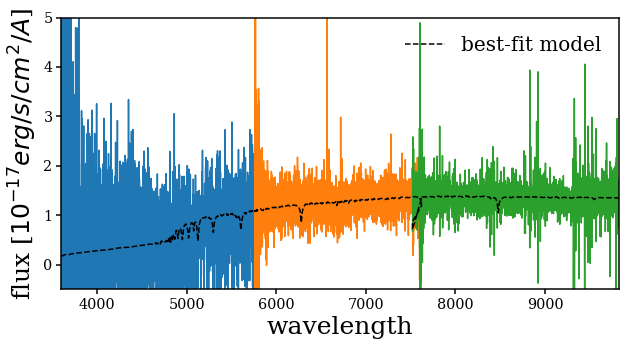

In [17]:
fig = plt.figure(figsize=(10,5))
sub = fig.add_subplot(111)
sub.plot(spectra.wave['b'], spectra.flux['b'][igal])
sub.plot(spectra.wave['r'], spectra.flux['r'][igal])
sub.plot(spectra.wave['z'], spectra.flux['z'][igal])
sub.plot(mcmc['wavelength_obs'], mcmc['flux_spec_model'], c='k', ls='--', label='best-fit model')
sub.legend(loc='upper right', fontsize=20)
sub.set_xlim(spectra.wave['b'].min(), spectra.wave['z'].max())
sub.set_xlabel('wavelength', fontsize=25)
sub.set_xlim(spectra.wave['b'].min(), spectra.wave['z'].max())
sub.set_ylabel('flux [$10^{-17} erg/s/cm^2/A$]', fontsize=25)
sub.set_ylim(-0.5, 5)

In [19]:
mcmc_chain = desi_mcmc._flatten_chain(mcmc['mcmc_chain'][500:,:,:])

In [22]:
print('median log(stellar mass) = %.2f' % np.median(mcmc_chain[:,0]))

median log(stellar mass) = 10.28


In [43]:
sfr_mcmc = m_sed.avgSFR(mcmc_chain, zred=zred, dt=1.)

In [45]:
print('median average SFR over 1 Gyr = %.2f' % np.median(sfr_mcmc))

median average SFR over 1 Gyr = 4.47


Too few points to create valid contours


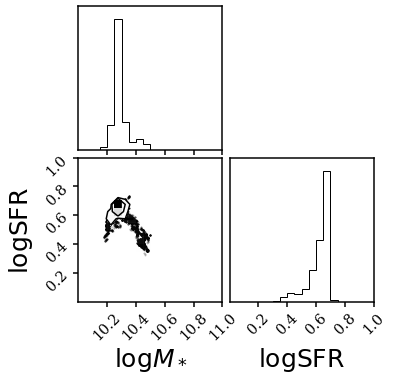

In [54]:
_ = corner.corner(np.array([mcmc_chain[:,0], np.log10(sfr_mcmc)]).T,
                  range=[(10., 11.), (0., 1.)], 
                  labels=[r'$\log M_*$', r'$\log {\rm SFR}$'], label_kwargs={'fontsize': 25})

In [26]:
t_lb, sfh_mcmc = m_sed.SFH(mcmc_chain, zred=zred)

In [29]:
sfh_q = np.quantile(sfh_mcmc, [0.16, 0.5, 0.84], axis=0)

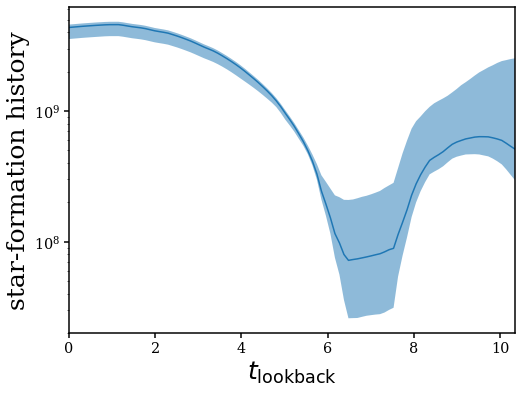

In [33]:
fig = plt.figure(figsize=(8,6))
sub = fig.add_subplot(111)
sub.fill_between(t_lb, sfh_q[0], sfh_q[2], alpha=0.5)
sub.plot(t_lb, sfh_q[1], c='C0', ls='-')
sub.set_xlabel(r'$t_{\rm lookback}$', fontsize=25)
sub.set_xlim(0., m_sed.cosmo.age(zred).value)
sub.set_ylabel('star-formation history', fontsize=25)
sub.set_yscale('log')